# Лабораторная работа №2 - Проверка качества генераторов псевдослучайных чисел

In [1]:
import math
import random

import matplotlib.pyplot as plt; plt.rcParams['figure.figsize'] = [10, 5]
import seaborn
import numpy as np
import scipy as sp

In [2]:
# Вариант 14 - метод Макларена-Марсальи

# Начальные параметры
k = 64
# Объем выборки
n = 1000
# Участков разбиения
N = 16

# Разделительный элемент
p = 0.45

In [3]:
class LabWork1_Pseudorandom_Generator:
    def __init__(self, n):
        self.n = n
        self.z = [random.random() for _ in range(n)]
    
    def gmm(self, k):     
        g1 = random.random()
        g2 = random.random()
        
        m = int(g2 * k)
        
        res = self.z[m]
        self.z[m] = g1
        
        return res

In [4]:
generator = LabWork1_Pseudorandom_Generator(n)
values = [generator.gmm(k) for _ in range(n)]

In [5]:
class LabWork2_Pseudorandom_Generator_Tester:
    def __init__(self, values, N, p):
        ''' Конструктор для класса лабораторной работы №2. '''

        self.sample = np.array(values)
        self.sample_size = len(self.sample)
        self.plots = N
        self.p = p

        self.theoretical_distribution = np.array([1000 / self.plots for _ in range(self.plots)])
        self.distribution = self.__get_distribution_from_sample(self.sample, self.plots)

        self.critical_values = {
            5.23: 0.99,
            6.26: 0.975,
            7.26: 0.95,
            8.55: 0.9    
        }

    def __get_distribution_from_sample(self, sample, plots):
        probabilities = {i: 0 for i in range(plots)}

        for value in sample:
            for i in range(N):
                if i / plots < value < (i + 1) / plots:
                    probabilities[i] += 1

        return np.array([i for i in list(probabilities.values())])

    def task1_1_scatter(self):
        """ Строит распределения на плоскости. """

        plt.title('Распределение на плоскости')
        seaborn.scatterplot(data=self.sample)

    def task1_2_histogram(self):
        """ Строит гистограмму частот """

        labels = range(16); x = np.arange(len(labels)); width = 0.9

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width / 2, self.distribution, width)
        ax.set_xticks(x)
        ax.set_title('Гистограмма частот')
        ax.set_xticklabels(labels)

        plt.show()

    def task2_pearson_criteria(self):
        """ Проверяет качество последовательности псевдослучайных чисел с помощью критерия χ² Пирсона. """

        χ, p_calc, dof, ct = sp.stats.chi2_contingency([self.distribution, self.theoretical_distribution])
        critical = sp.stats.chi2.ppf(χ, dof)
        p_table = self.critical_values[min(self.critical_values, key=lambda x: abs(x - critical))]
        return χ, p_calc, p_table, dof, critical

    def task3_kolmogorov_criteria(self):
        """ Проверяет качество последовательности псевдослучайных чисел с помощью критерия Колмогорова. """

        return sp.stats.ks_2samp(self.distribution, self.theoretical_distribution)

    def __get_list_of_hypothses(self, ts, mean, variance, k0):
        VH = [mean - t * math.sqrt(variance / k0) for t in ts]
        VB = [mean + t * math.sqrt(variance / k0) for t in ts]

        return VH, VB

    def task4_series_of_zeros_test(self):
        """ Проверяет качество последовательности псевдослучайных чисел с помощью теста серий нулей. """

        series = [1 if element <= self.p else 0 for element in self.sample]

        k0, n0 = 0, 0
        for i in range(1, self.sample_size):
            if series[i - 1] == 0 and series[i] == 1:
                k0 += 1
        for i in range(self.sample_size):
            if series[i] == 0:
                n0 += 1
        if series[self.sample_size - 1] == 0:
            k0 += 1

        mean = (1 - self.p) / self.p + 1
        variance = (1 - self.p) / self.p ** 2
        average = n0 / k0

        relialibilies = [0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999]
        t_betas = [1.65, 1.96, 2.06, 2.18, 2.33, 2.58, 3.3]
        VH, VB = self.__get_list_of_hypothses(t_betas, mean, variance, k0)

        results = []
        for i in range(len(t_betas)):
            result = "подтверждается" if VH[i] < average < VB[i] else "отвергается"
            results.append(f"При уровне значимости {relialibilies[i]} гипотеза {result}, {round(VH[i], 2)} < {round(average, 2)} < {round(VB[i], 2)}")

        return series, mean, variance, average, k0, results

    def test(self):
        print(self.distribution)
        print(self.theoretical_distribution)

# Выполнение

In [6]:
lab2 = LabWork2_Pseudorandom_Generator_Tester(values, N, p)

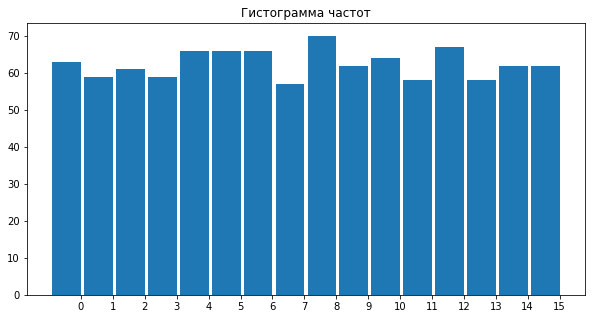

In [7]:
lab2.task1_2_histogram()

In [8]:
χ, p_calc, p_table, dof, critical = lab2.task2_pearson_criteria()

print(f"""
χ² = {χ}
Уровень надежности: p = {p_calc}
Степеней свободы: {dof}
Критическое значение: {critical}
""")


χ² = 1.7017962400719648
Уровень надежности: p = 0.9999899396284923
Степеней свободы: 15
Критическое значение: nan



In [9]:
λ, p = lab2.task3_kolmogorov_criteria()

print(f"""
λ = {λ}
Уровень надежности (p): {1 - p}
Вероятность равномерного распределения: {1 - sp.stats.kstwo.ppf(λ, 15)}
""")


λ = 0.5625
Уровень надежности (p): 0.9888006461165701
Вероятность равномерного распределения: 0.7859993330704398



In [10]:
series, mean, variance, average, k0, results = lab2.task4_series_of_zeros_test()

print(f"""
Математическое ожидание: M(V) = {mean}
Дисперсия: D(V) = {variance}
Оценка среднего числа нулей в серии: Mᴠ = {average}
K₀ = {k0}
""")

print(*results, sep="\n")


Математическое ожидание: M(V) = 2.2222222222222223
Дисперсия: D(V) = 2.7160493827160495
Оценка среднего числа нулей в серии: Mᴠ = 2.231707317073171
K₀ = 246

При уровне значимости 0.9 гипотеза подтверждается, 2.05 < 2.23 < 2.4
При уровне значимости 0.95 гипотеза подтверждается, 2.02 < 2.23 < 2.43
При уровне значимости 0.96 гипотеза подтверждается, 2.01 < 2.23 < 2.44
При уровне значимости 0.97 гипотеза подтверждается, 1.99 < 2.23 < 2.45
При уровне значимости 0.98 гипотеза подтверждается, 1.98 < 2.23 < 2.47
При уровне значимости 0.99 гипотеза подтверждается, 1.95 < 2.23 < 2.49
При уровне значимости 0.999 гипотеза подтверждается, 1.88 < 2.23 < 2.57
